In [1]:
import pandas_datareader as pdr
import datetime 
import pandas_ta as ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

In [2]:
# data = dataframe in pandas format to calculate sma
# sma_value = is an array to calcuate the lenth of sma 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
def sma(data,sma_value,variable):
     # auto assign a variable name based on length of sma 
    variable_name = 'SMA'+ str(sma_value)
    # calculate sma 
    data[variable_name] =ta.sma(data[variable], length=sma_value)
    # return sma variable calculated 
    return data[variable_name]
# sym =  string format, ticker name
# ema value = is an array to calcuate the lenth of ema 
# sma_value = is an array to calcuate the lenth of sma 
# close = variable use for calcuate sma and ema, either "Close"or "Adj Close" in string format
def getdata(sym,sma_value,close):
    today = datetime.datetime.now()
    df = pdr.get_data_yahoo(sym, start=datetime.datetime(today.year-10,today.month, 1),
                                    end=datetime.datetime(today.year, today.month, today.day)).reset_index()
    df['ticker'] =sym
        
    for i in sma_value:
        variable_name = 'SMA'+ str(i)
        df[variable_name] = sma(df,i,close)
    return df

In [3]:
def Generate_signal(data, variable_triggered):    
    #table start
    df_init =  data.copy()
    
    '''To make sure row arrange in an ascending order'''
    df.sort_values(by = 'Date',inplace=True)
    
    '''Process data by remove Null value in moving average varaible that your want to used for triggered''' 
    df_init.dropna(subset=[variable_triggered,'SMA200'],inplace=True)
    '''generate as 1 if Adj close is higher than variable you want to test, generate as -1 if Adj close is less than the
    variable you want to test in a signal variable  
    '''
    # create a signal variable
    df_init['signal'] = np.nan 
    # trigger a buy only if it is a up trend 
    df_init.loc[(df['Adj Close']>=df[variable_triggered]) &(df[variable_triggered]>=df['SMA200']) ,'signal'] = 1
    
    # just triggered sell as close is less than variable triggered
    df_init.loc[(df['Adj Close']<df[variable_triggered]),'signal'] = -1
    
    # if close > variable triggered but sma20<= sma 200, let it be do nothing
    df_init.loc[(df['Adj Close']>=df[variable_triggered]) &(df[variable_triggered]<df['SMA200']) ,'signal'] =0
    
    ''' move the signal of today to tmr, thus, we need to define a shift(1), as the signal buy is based on yesterday'''
    df_init['signal'] = df_init['signal'].shift(1)
    
    '''after we have a buy and sell signal, lets create a hold signal which is equal to 2 after a buy signal and
    a do nothing signal which is equal to 0 after a sell signal'''
    
    # In order to make a decision on a hold or do nothing signal based on yesterday signal we need to create a for loop 
    # a calendar date should be created to used for a a for loop 
    date_list = df_init.Date.unique()
    
    # declare a first day, the first date is a null in signal as there is no yesterday data for first data
    first_date = date_list[0]
    
    # declare a previous day 
    prev = first_date 
    
    for i in date_list:
        if i == first_date:
            df_init.loc[df_init.Date == i,'signal'] = 0 
        else:
            # if you have a sell signal yesterday, you should have a do nothing signal today
            if (df_init.loc[df_init.Date == prev,'signal'].values[0]==-1):
                df_init.loc[df_init.Date == i,'signal']=0 
            # if you have a buy signal yesterday, you should have a hold signal today
            elif (df_init.loc[df_init.Date == prev,'signal'].values[0]==1):
                df_init.loc[df_init.Date == i,'signal'] = 2
              
            # if you have a hold signal yesterday and you do not have a sell signal today, you should have a hold signal today
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==2)&(df_init.loc[df_init.Date == i,'signal'].values[0]!=-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 2
                
            # if you have a do nothing signal yesterday and today is a sell signal, you should equal to have a do nothing signal
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==0)&(df_init.loc[df_init.Date == i,'signal'].values[0]==-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 0
                
        # redeclare your previous date before to next day in for loop
        prev = i
    
    return df_init
    

In [4]:
from statistics import mean
def backtest_strategy(data,capital):   
    
    #table start
    df_init =  data.copy()
    df_init.set_index('Date',inplace=True) 
    
    #assign dummy row - day before the trade
    start_date = pd.DataFrame(columns=data.columns,index=[df_init.index.min()- datetime.timedelta(days=1)])
    df_init = df_init.append(start_date)
    
    #initiat 2 variable: cash and units which represent each status of cash and units of apple holding for each day
    df_init = df_init.assign(cash=np.nan,units = 0)
    
    #assign capital for first dummy day assigned to be capital defined in function
    df_init.loc[pd.Series(df_init.index.min()), 'cash'] = capital
    
    # obtain list of calendar 
    calendar = pd.Series(df_init.index.sort_values().unique()).iloc[1:]
    
    ''' assign a variable which is trade, earn trade and lost trade to calculate total number of trade, total earn trade 
    and total lost trade'''
    trade = 0
    earn_trade = 0
    loss_trade = 0
    
    ''' create an array to keep all earn value and lost value for each trade'''
    earn_value =[]
    lost_value =[]

    for date in calendar:
        
        #get yesterday data
        prev_date = df_init.index[df_init.index<date].unique().sort_values()[-1]
        
        # calculate total stock value of yesterday 
        stock_holding = df_init.loc[(df_init.index==prev_date), 'units'].values[0]*df_init.loc[(df_init.index==date),'Price'].values[0]
        
        # total portfolio value by add cash and stock value of yesterday 
        port_value = stock_holding + df_init.loc[prev_date, 'cash'].sum()

        # if signal is do nothing, mean our cash = portfolio value and units=0
        if df_init.loc[(df_init.index==date), 'signal'].values[0] == 0:          
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value        
        #if we have a buy signal 
        #start to calculate the trade
        #we start to calculate start_cap which represent the starting capital for each trade
        #unit_buy is total unit buy based on port_value available
        elif df_init.loc[(df_init.index==date), 'signal'].values[0] == 1:
            trade+=1
            start_cap = port_value 
            unit_buy = port_value/df_init.loc[(df_init.index==date), 'Price'].values[0]
            df_init.loc[(df_init.index==date), 'units'] = unit_buy
            df_init.loc[(df_init.index==date), 'cash'] = port_value - unit_buy*df_init.loc[(df_init.index==date), 'Price'].values[0]        
        
        #if we have a hold signal or do nothing signal,
        #mean today units hold and cash are same as yesterday units hold and yesterday cash
        elif ((df_init.loc[(df_init.index==date), 'signal'].values[0] == 2) | (df_init.loc[(df_init.index==date), 'signal'].values[0] == 0)): 
            df_init.loc[(df_init.index==date), 'units'] = df_init.loc[(df_init.index==prev_date), 'units'].values[0]
            df_init.loc[(df_init.index==date), 'cash'] =df_init.loc[(df_init.index==prev_date), 'cash'].values[0]
        
        #if we have a sell signal,
        #1. we sell all the units at the today open price and thus units =0 and cash = port_value
        #2. we calculate the total earn/lost of this trade by using port_value - start cap of the trade and store as v variable
        #3. if v> 0, we store as earn_value array
        #4. if v<0, we store as lost trade
        elif (df_init.loc[(df_init.index==date), 'signal'].values[0] == -1):
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value 
            if (start_cap is None):
                0
            else:
                v = port_value  - start_cap 
                if v> 0: 
                    earn_value.append(v)
                    earn_trade +=1
                elif v<0: 
                    lost_value.append(v)
                    loss_trade+=1

    # calculate current value of the strategy, the formula = unit holding * Price + cash available
    df_init['Total_value_todate'] = df_init['units']*df_init['Price'] + df_init['cash'] 
    
    # append 0 to earn value array to prevent later calculation fail if there is no any earn trade
    earn_value.append(0)
    #remove dummy rows
    df_init.drop(df_init[df_init.index == df_init.index.min()].index,axis=0,inplace=True)
  
    # get summarize of total portfolio value, return by date, benchmark_index
    total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate'].sum())
    total_port_value['Return_without_trailing'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].iloc[0] *100
    total_port_value['Return_trailing_12m'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].shift(12)*100

    # to print out statistic to know how your strategy perform and the win change of this strategy
    print('total_trade:',trade)
    print('earn_trade:',earn_trade)
    print('lost_trade:',loss_trade)
    print('win_chance:',earn_trade/trade)
    print('Max earning:',max(earn_value))
    print('Max lost:',min(lost_value))
    print('Average lost:',mean(lost_value))
    print('Average Win:',mean(earn_value))
    return total_port_value, df_init

In [5]:
# annualized return 
# df =data with return 
# variable = variable name of return
def annualized(df,variable):
    days_held =df.shape[0]
    Return = (df.iloc[-1][variable] - df.iloc[0][variable])/df.iloc[0][variable]
    ar = ((1+Return) ** (365/days_held))-1
    # get annualized in %
    return ar*100
# maximum drawdown 
# df =data with return 
# variable = variable name of return
def MDD(df,variable):
    window = 252
    Roll_Max = df[variable].rolling(window, min_periods=1).max()
    Drawdown = df[variable]/Roll_Max - 1.0
    mdd = Drawdown.min()
    # get drawdown in %
    return mdd*100

In [6]:
df = getdata('AAPL',sma_value = [20,50,200],close = "Adj Close")
print (df.head(21))

         Date       High        Low       Open      Close        Volume  \
0  2012-10-31  21.498571  20.989286  21.245714  21.261429  5.100032e+08   
1  2012-11-01  21.535713  21.220358  21.365000  21.305000  3.612980e+08   
2  2012-11-02  21.319643  20.526787  21.281786  20.600000  5.993736e+08   
3  2012-11-05  20.991785  20.628571  20.840000  20.879286  5.291356e+08   
4  2012-11-06  21.097857  20.717501  21.079643  20.816071  3.749172e+08   
5  2012-11-07  20.519285  19.848213  20.494286  19.928572  7.936488e+08   
6  2012-11-08  20.079643  19.117500  20.022499  19.205357  1.056146e+09   
7  2012-11-09  19.817142  19.061428  19.300714  19.537857  9.299136e+08   
8  2012-11-12  19.803572  19.237499  19.791071  19.386786  5.158020e+08   
9  2012-11-13  19.660000  19.155714  19.246786  19.389286  5.329492e+08   
10 2012-11-14  19.551786  19.149286  19.482143  19.174286  4.771704e+08   
11 2012-11-15  19.267857  18.665001  19.197500  18.772142  7.899108e+08   
12 2012-11-16  18.928572 

In [7]:
# Get signal
df_signal = Generate_signal(df, 'SMA20')
# back test your strategy using Open price as price action to buy sell on particular day
df_signal['Price']=df_signal['Open']
df_backtest = df_signal[['Date','Price','signal','Open']].copy()
result, hold_detail = backtest_strategy(df_backtest,1000)

total_trade: 85
earn_trade: 36
lost_trade: 49
win_chance: 0.4235294117647059
Max earning: 789.6174725358806
Max lost: -293.0306935090057
Average lost: -53.43959754383326
Average Win: 166.81724809440993


In [8]:
# calculate the return without trailing of hold without sell 
df_signal['hold_without_sell_return (%)'] = df_signal['Close']/df_signal['Close'].iloc[0]*100
result['hold_without_sell_return (%)'] = df_signal.set_index('Date')['hold_without_sell_return (%)']

Annualized_return of SMA20 strategy: 26.830268476939565
MDD of SMA20 strategy: -19.326880963673286
Annualized_return of hold without sell: 39.46397224418477
MDD of hold without sell: -38.72969450862453


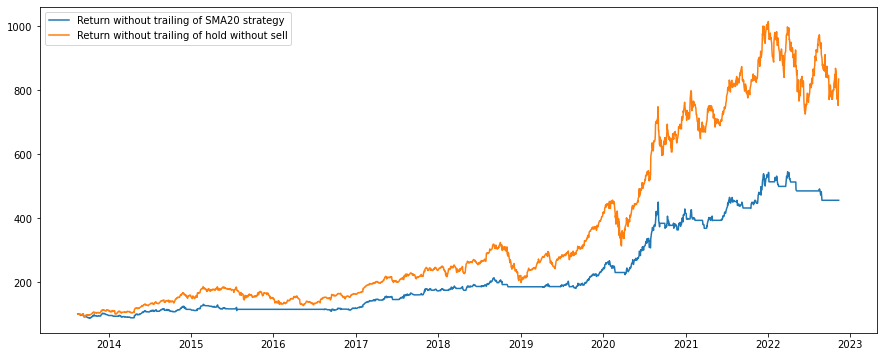

In [9]:
# plot the return and calculate the annualized return and MDD (maximum draw down) for both strategy
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(result.Return_without_trailing, label='Return without trailing of SMA20 strategy')
plt.plot(result['hold_without_sell_return (%)'], label='Return without trailing of hold without sell')
plt.legend()
print('Annualized_return of SMA20 strategy:',annualized (result,'Return_without_trailing'))
print('MDD of SMA20 strategy:', MDD(result,'Return_without_trailing'))

print('Annualized_return of hold without sell:',annualized (result,'hold_without_sell_return (%)'))
print('MDD of hold without sell:', MDD(result,'hold_without_sell_return (%)'))